In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
col_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('AEP_hourly.csv')

In [3]:
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df.tail()

,Datetime,AEP_MW
121268,2018-01-01 20:00:00,21089.0
121269,2018-01-01 21:00:00,20999.0
121270,2018-01-01 22:00:00,20820.0
121271,2018-01-01 23:00:00,20415.0
121272,2018-01-02 00:00:00,19993.0


In [5]:
df =  pd.read_csv('AEP_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


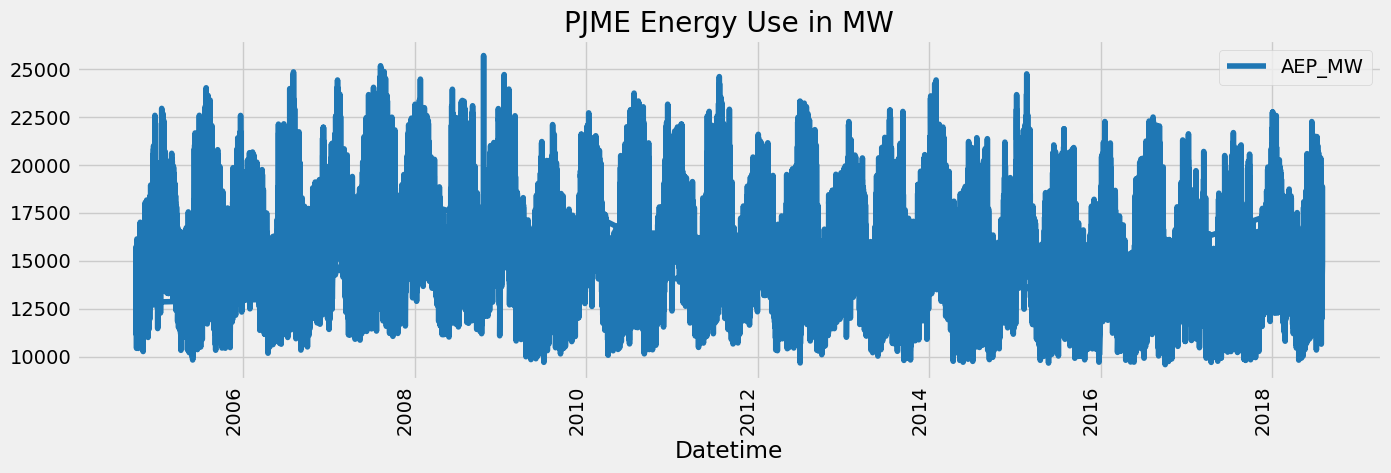

In [7]:
df.plot(style='-', figsize=(15,5),color=col_pal[0], title='PJME Energy Use in MW')
plt.xticks(rotation=90)
plt.show();

## TRAIN TEST SPLIT

In [9]:
train = df.loc[df.index < '01-01-2015'] #We train all data sets from 2015 to 2018
test  =  df.loc[df.index >= '01-01-2015'] #Test dataset of 2004 to 2015

In [10]:
test

,AEP_MW
Datetime,
2015-01-01 00:00:00,16375.0
2015-12-31 01:00:00,12415.0
2015-12-31 02:00:00,12087.0
2015-12-31 03:00:00,12010.0
2015-12-31 04:00:00,11972.0
...,...
2018-01-01 20:00:00,21089.0
2018-01-01 21:00:00,20999.0
2018-01-01 22:00:00,20820.0


In [11]:
train

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0
...,...
2014-01-01 20:00:00,16433.0
2014-01-01 21:00:00,16376.0
2014-01-01 22:00:00,16151.0


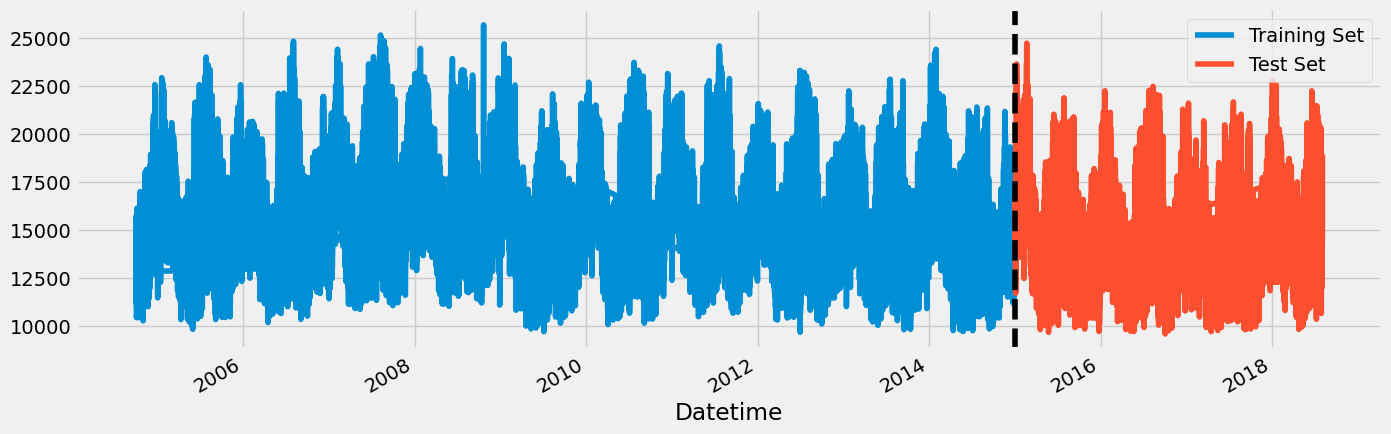

In [12]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label= 'Training Set')
test.plot(ax=ax, label= 'Test Set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

#### ONE WEEK DATA ANALYSIS

In [14]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')]

,AEP_MW
Datetime,
2010-01-07 01:00:00,18483.0
2010-01-07 02:00:00,18088.0
2010-01-07 03:00:00,17984.0
2010-01-07 04:00:00,17978.0
2010-01-07 05:00:00,18300.0
...,...
2010-01-01 20:00:00,18590.0
2010-01-01 21:00:00,18492.0
2010-01-01 22:00:00,18466.0


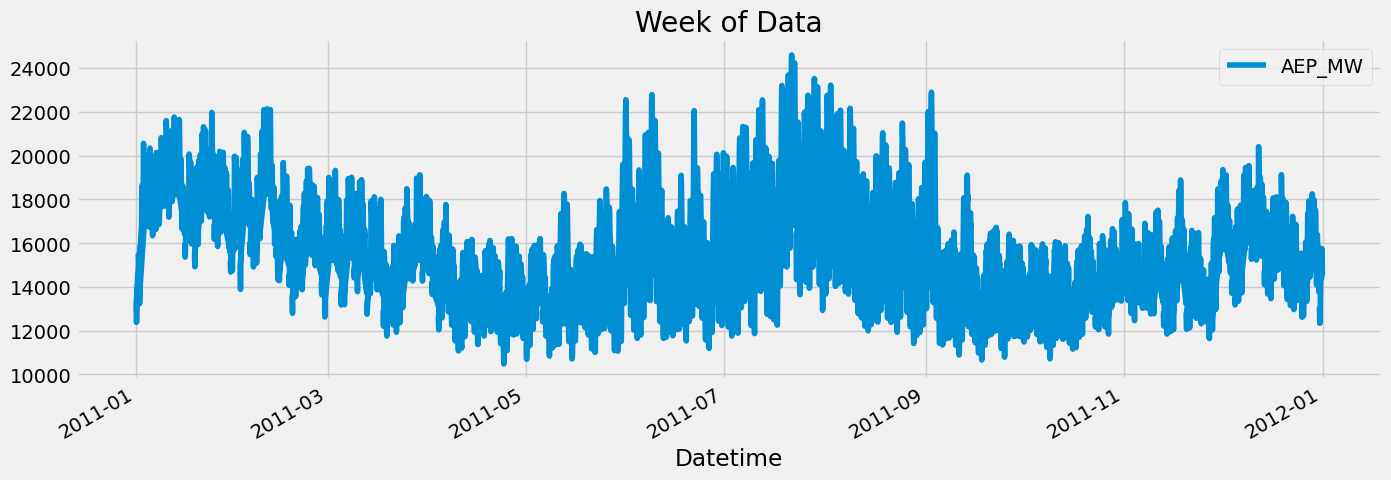

In [15]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-01-2012')].plot(figsize=(15,5),title='Week of Data')
plt.show()

### FEATURE (DATETIME) CREATION

In [17]:
def create_features(df):
    '''
    create time series based on time series index
    '''
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

    df = create_features(df)

In [18]:
df.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [19]:
df = create_features(df)

In [20]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


In [21]:
df['dayofweek'].unique()

array([4, 5, 3, 2, 1, 0, 6])

In [22]:
df['hour'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  0])

In [23]:
df['year'].unique()

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018])

In [24]:
df['month'].unique()

array([12,  1, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2])

## DATA VIZZ

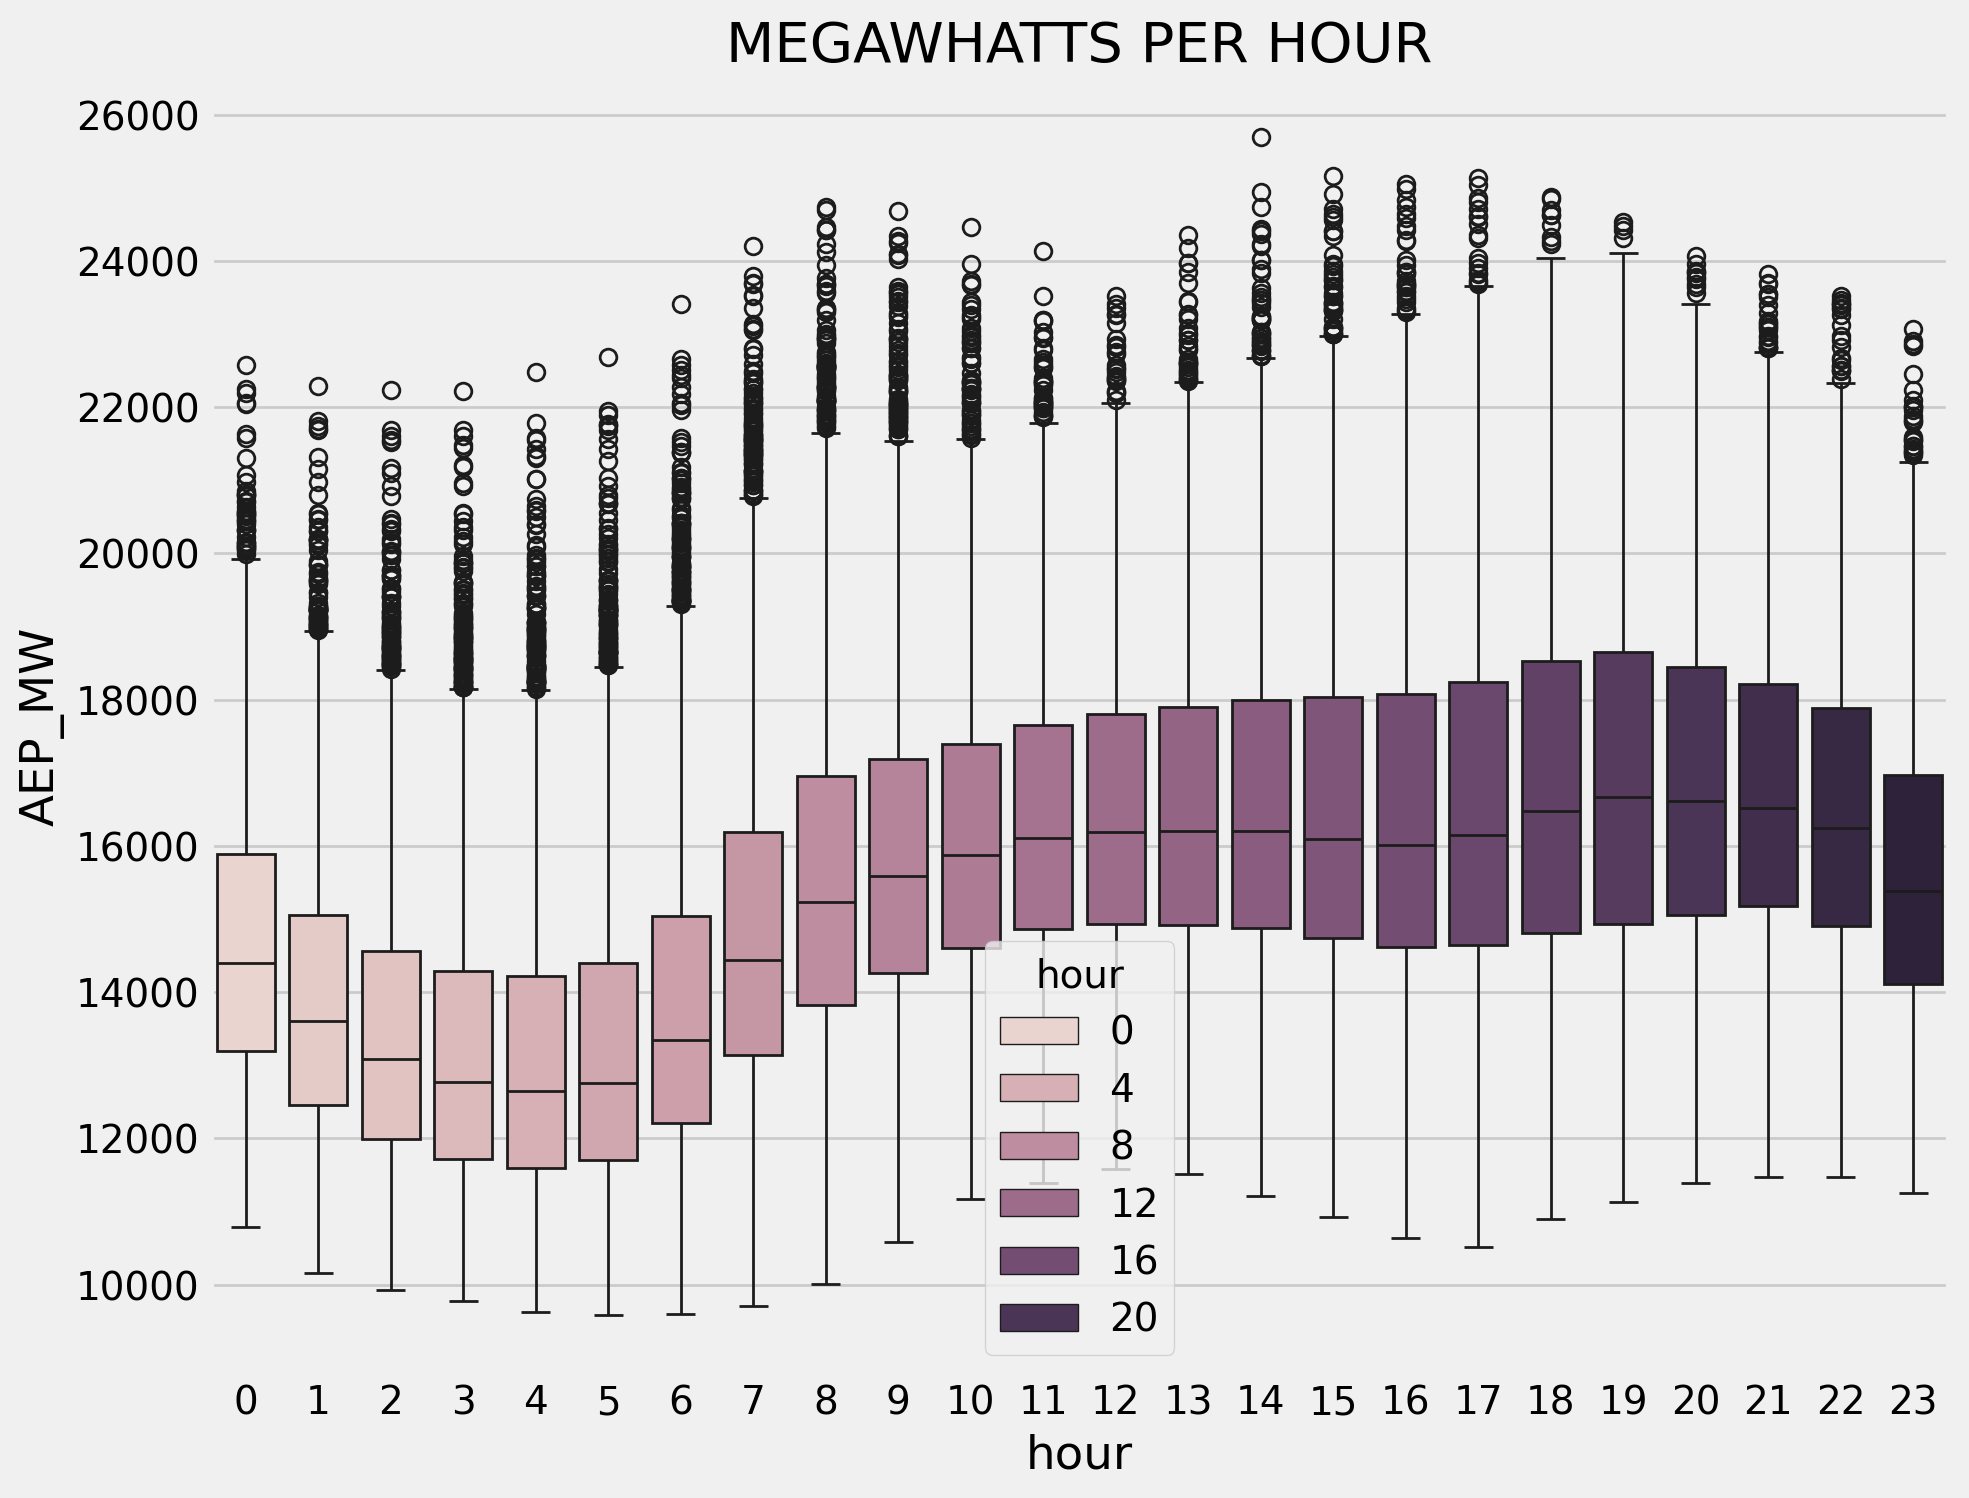

In [26]:
fig, ax = plt.subplots(figsize=(10,8),dpi=200)
sns.boxplot(data=df, x='hour',y='AEP_MW',hue='hour')
ax.set_title('MEGAWHATTS PER HOUR')
plt.show()

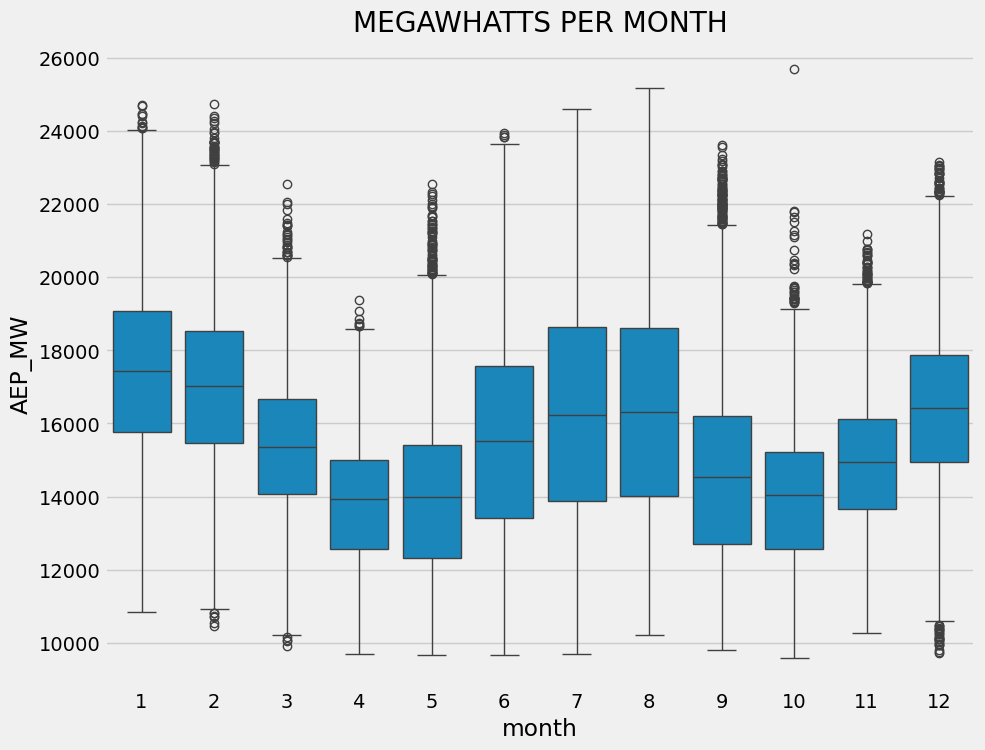

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month',y='AEP_MW')
ax.set_title('MEGAWHATTS PER MONTH')
plt.show()

## CREATE A MODEL

#### REGRESSION TASK

In [30]:
reg = xgb.XGBRegressor(n_estimators=1000) # estimator is number of trees

In [31]:
train = create_features(train)
test = create_features(test);

C:\Users\User\AppData\Local\Temp\ipykernel_6420\3720489749.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\User\AppData\Local\Temp\ipykernel_6420\3720489749.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.day_of_week
C:\Users\User\AppData\Local\Temp\ipykernel_6420\3720489749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [32]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [33]:
FEATURES = ['hour', 'dayofweek', 'quarter',
            'month', 'year', 'dayofyear']
target = 'AEP_MW'

In [34]:
X_train = train[FEATURES]
y_train = train[target]

X_test = test[FEATURES]
y_test = test[target]

In [35]:
reg = xgb.XGBRegressor(n_estimators = 100, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[99]	validation_0-rmse:1672.28090	validation_1-rmse:1910.01646


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

##### Feature Importances

In [37]:
reg.feature_importances_

array([0.38950163, 0.16908047, 0.03101843, 0.24623305, 0.02736157,
       0.1368048 ], dtype=float32)

In [38]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index = reg.feature_names_in_,
            columns=['importance'])

In [39]:
fi

,importance
hour,0.389502
dayofweek,0.169080
quarter,0.031018
month,0.246233
year,0.027362
dayofyear,0.136805


In [40]:
sort = fi.sort_values('importance',ascending=False)

In [41]:
sort

,importance
hour,0.389502
month,0.246233
dayofweek,0.169080
dayofyear,0.136805
quarter,0.031018
year,0.027362


<Axes: title={'center': 'Feature Importance'}>

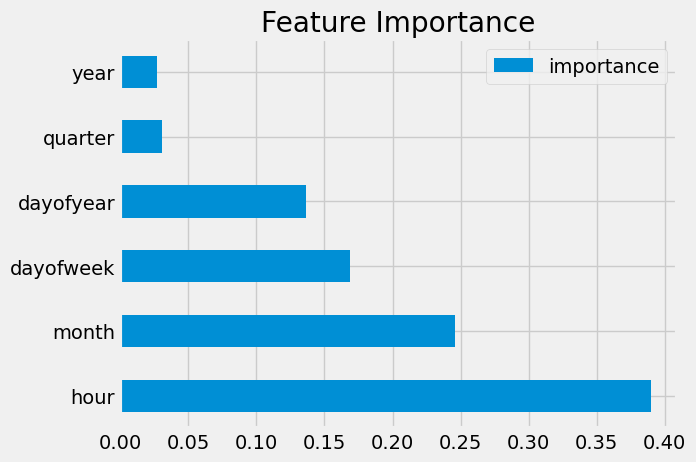

In [42]:
sort.plot(kind='barh', title ='Feature Importance')

### FORECAST ON TEST

In [44]:
test['predictions'] = reg.predict(X_test)

C:\Users\User\AppData\Local\Temp\ipykernel_6420\118111341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = reg.predict(X_test)


In [45]:
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366


### Merge the test['predictions'] with the main df dataframe

In [47]:
df = df.merge(test[['predictions']], how='left',left_index=True, right_index=True)

In [51]:
df.head(3)

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,predictions
Datetime,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,NaN
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,NaN
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,NaN


In [53]:
df.columns

Index(['AEP_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'predictions'],
      dtype='object')

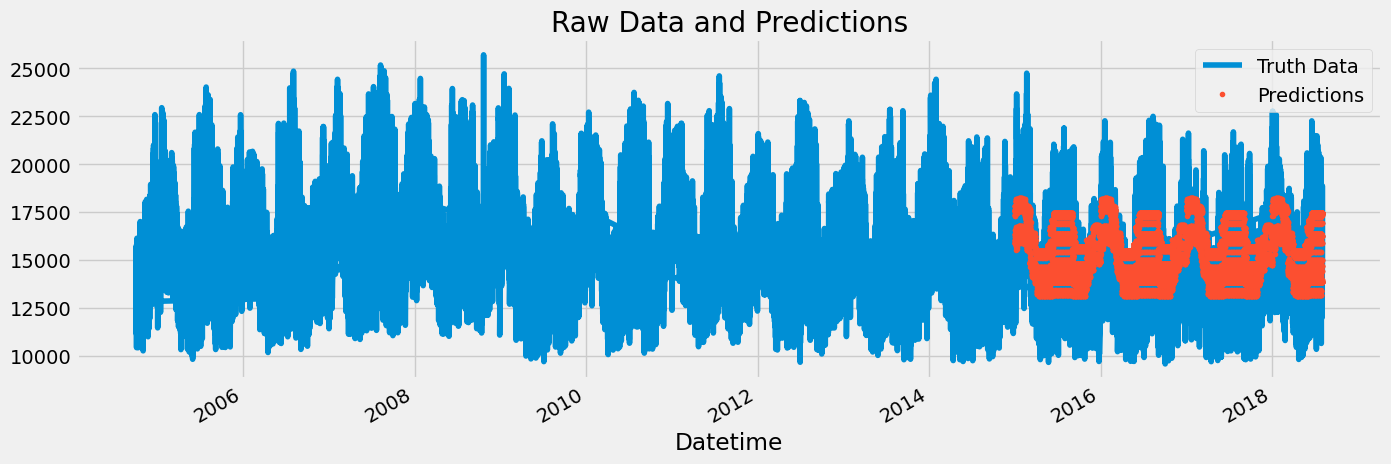

In [57]:
test['predictions'] = reg.predict(X_test)
df = df.merge(test[['predictions']], how='left',left_index=True, right_index=True)
ax = df[['AEP_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show();

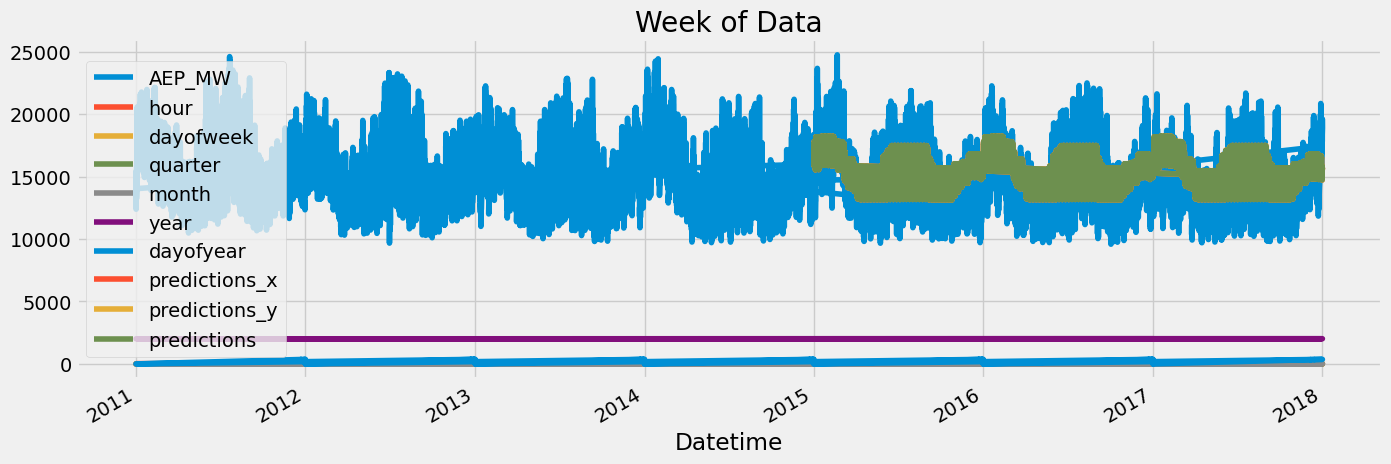

In [61]:
df.loc[(df.index > '01-01-2011') & (df.index < '01-01-2018')].plot(figsize=(15,5),title='Week of Data')
plt.show()

In [71]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1910.02


## CALCULATE ERROR

###### Look at the worst and best predicted days

In [75]:
test['error'] = np.abs(test[target] - test['predictions'])

In [79]:
test.index.date

array([datetime.date(2015, 1, 1), datetime.date(2015, 12, 31),
       datetime.date(2015, 12, 31), ..., datetime.date(2018, 1, 1),
       datetime.date(2018, 1, 1), datetime.date(2018, 1, 2)], dtype=object)

## Worst predicted days

In [89]:
test['error'] = np.abs(test[target] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(5)

date
2015-02-19    5411.262777
2015-02-20    5271.771729
2015-12-25    4974.066976
2018-01-06    4776.784709
2015-12-24    4575.868327
Name: error, dtype: float64

## Best Predicted days

In [92]:
test['error'] = np.abs(test[target] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(5)

date
2018-08-03    212.313477
2017-02-03    363.150838
2016-03-04    368.717855
2017-12-17    395.454915
2016-02-26    395.862467
Name: error, dtype: float64